# Customer Personality Analysis with KMeans
Data source: https://www.kaggle.com/imakash3011/customer-personality-analysis

The analysis will assist the company to classify each customers into segment based on their similarities in purchasing the product and also know the products that are mostly purchased by each customers segment so as to channel the product to them explicitly inorder to increase the avaliabity of the major demanding product by each segment and reduce the excess of less demanding product.

For the customer personality analysis KMeans clustering algorithm was used to segment the customers into groups based on their purchased activity.

## Importing libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import plotly.express as px

import sklearn
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep = '\t')  
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


## Data preprocessing:
###  Data cleaning
To remove errors and modify incorrect input

Examing 'MARKETING DATA'
Rows and column shape: (2240, 29)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 no

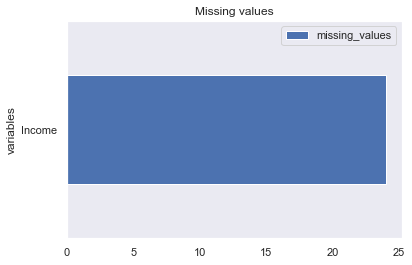

In [3]:
def examine_data(data, data_name = 'data'):
    print(f"Examing '{data_name}'")
    print(f'Rows and column shape: {df.shape}\n')
    print(f'{df.info()}\n')


    # duplicate values
    duplicate = df.duplicated().sum()
    if duplicate == 0:
        print(f'Duplicate values:\n No duplicate in the {data_name}.\n')
    else:
        print(f'There are {duplicate} duplicate in the {data_name}.\n')
        
    # missing values
    print('Missing values:')
    missing = pd.DataFrame(df.isna().sum().to_frame().reset_index().\
    rename({'index': 'variables', 0: 'missing_values'}, axis = 1))
    nan_rows = missing[missing['missing_values'] > 0]
    if nan_rows['missing_values'].sum() > 0:
        nan_rows.plot(x = 'variables', y = 'missing_values', kind = 'barh') 
        plt.title('Missing values')
        plt.grid()
    else:
        print(f'There are no missing values in {data_name}.') 
    
examine_data(df, data_name = 'MARKETING DATA')

Check income distribution to handle missing rows

In [4]:
def viz_dist(data, column):
    fig = px.histogram(data, column, 
                       width = 600, 
                       height = 300, 
                       color_discrete_sequence = ['darkblue'])
    fig.show()
    
viz_dist(df, 'Income')

Handling missing values: Income column is not symmetric, it is skewed, so we cant fill with mean, for the objective of the analysis, customers with missing income value ideally did not input their income or it was not stored, for accuracy we will remove customers with no income value.

In [5]:
df.dropna(inplace = True)

Correlation between variable

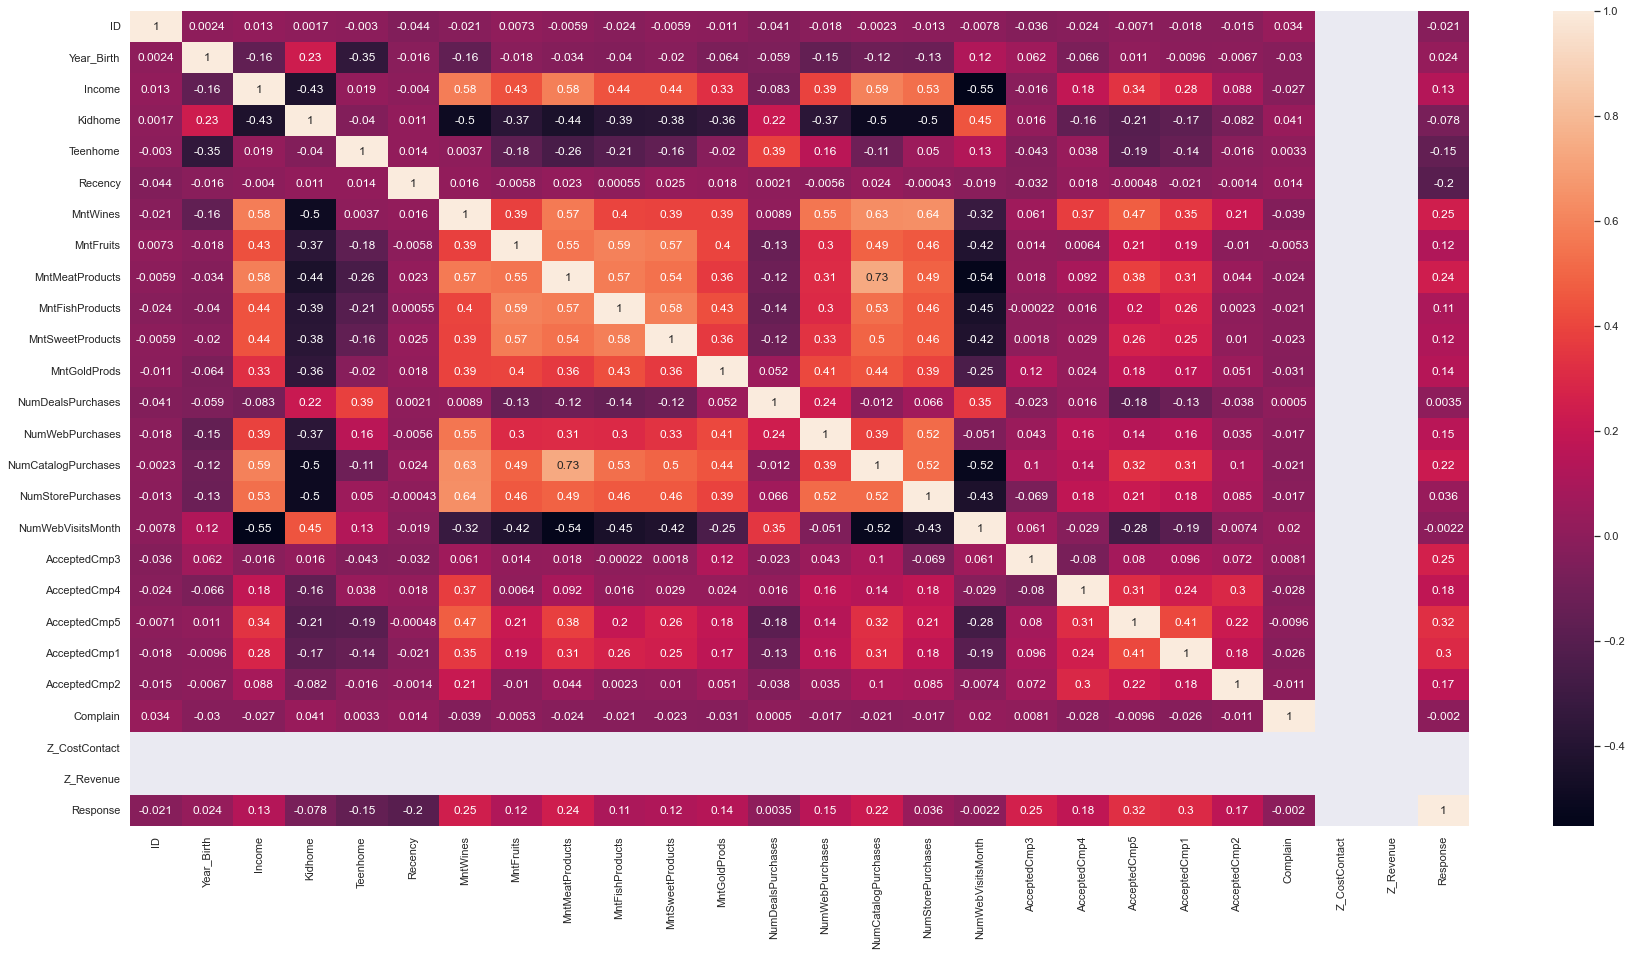

In [6]:
df.corr()
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot= True);

Z_CostContact and Z_Revenue as seen in the correlation heatmap have the same values in all its column, these column will be dropped as they do not represent a statistical significant feature to the model.

In [7]:
df.drop(['Z_CostContact', 'Z_Revenue'], axis = 1, inplace = True)

### Data wrangling
Feature Engineering: formatting the data into meaningful format for analysis.

In [8]:
# check the max year of customer erollment 
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
max(df['Dt_Customer'])

Timestamp('2014-12-06 00:00:00')

In [9]:
# create new column '2014' to get year since erolled
df['2014'] ='2014-12-31'
df['2014'] = pd.to_datetime(df['2014'])
df['customers_engagement'] = (df['2014'].dt.year) - (df['Dt_Customer'].dt.year)  

# customers age
df['age'] = 2014 - df['Year_Birth']

# number of kids
df['kids'] = df['Kidhome'] + df['Teenhome']
     
# total amount spent
df['total_amount_spent'] = df['MntWines'] + df['MntFruits']\
    + df['MntMeatProducts'] + df['MntFishProducts']\
    + df['MntSweetProducts'] + df['MntGoldProds']

# rename product name
df = df.rename(columns ={'MntWines': 'wines', 'MntFruits':'fruits','MntMeatProducts':'meat','MntFishProducts':'fish',\
    'MntSweetProducts':'sweets','MntGoldProds':'gold'})

# delete redundant columns to reduce complexity on model
df.drop(['Year_Birth', 'Dt_Customer', 'Kidhome', 'Teenhome','AcceptedCmp3',\
         'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp4', 'AcceptedCmp5',\
         'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',\
         'NumDealsPurchases', 'NumWebVisitsMonth', '2014', 'Complain',\
         'Response', 'Recency'], axis = 1, inplace = True)

df.head()

,ID,Education,Marital_Status,Income,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent
0,5524,Graduation,Single,58138.0,635,88,546,172,88,88,2,57,0,1617
1,2174,Graduation,Single,46344.0,11,1,6,2,1,6,0,60,2,27
2,4141,Graduation,Together,71613.0,426,49,127,111,21,42,1,49,0,776
3,6182,Graduation,Together,26646.0,11,4,20,10,3,5,0,30,1,53
4,5324,PhD,Married,58293.0,173,43,118,46,27,15,0,33,1,422


In [11]:
print(f'Categories in marital status:\n {df["Marital_Status"].value_counts()},\n')
print(f'Categories in education:\n {df["Education"].value_counts()}')

Categories in marital status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64,

Categories in education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [42]:
def replace_values():
    for value in df['Marital_Status']:
        if value == 'Married' or value == 'Together':
            df['Marital_Status'] == 'In relationship'
            print(df['Marital_Status'])
        else:
            df['Marital_Status'] == 'Single'
            print(df['Marital_Status'])

replace_values()    

SyntaxError: invalid syntax (3452316862.py, line 5)

In [26]:
df.head()

,ID,Education,Marital_Status,Income,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent
0,5524,Graduation,Single,58138.0,635,88,546,172,88,88,2,57,0,1617
1,2174,Graduation,Single,46344.0,11,1,6,2,1,6,0,60,2,27
2,4141,Graduation,Together,71613.0,426,49,127,111,21,42,1,49,0,776
3,6182,Graduation,Together,26646.0,11,4,20,10,3,5,0,30,1,53
4,5324,PhD,Married,58293.0,173,43,118,46,27,15,0,33,1,422


In [18]:
# replace values in column to a more precised category 
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'], 'In relationship')

df['Marital_Status'] = df['Marital_Status'].replace(['Single', 'Divorced','Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')


# replace values in column to a more precised category for 'education'
df.Education = df.Education.replace(['Graduation', 'PhD', 'Master', '2n Cycle'],'PG')
df.Education = df.Education.replace(['Basic'], 'UG')

display(f'New row and column shape: {df.shape}')
df.head()

'New row and column shape: (2216, 14)'

,ID,Education,Marital_Status,Income,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent
0,5524,PG,Single,58138.0,635,88,546,172,88,88,2,57,0,1617
1,2174,PG,Single,46344.0,11,1,6,2,1,6,0,60,2,27
2,4141,PG,In relationship,71613.0,426,49,127,111,21,42,1,49,0,776
3,6182,PG,In relationship,26646.0,11,4,20,10,3,5,0,30,1,53
4,5324,PG,In relationship,58293.0,173,43,118,46,27,15,0,33,1,422


Rename column name into appropriate format

In [19]:
df.columns = df.columns.str.lower()

### Handling outliers
Outlier are completely different data (numerical data type) from the dataset.

In [20]:
viz_dist(df, 'age')

Remove outliers
1. There're outliners in age and income column.
2. It is observed that majority of our customers earn between <= 90k, income above 600,000 will be removed.
3. Age greater than 100 will be remove, these customers can be treated differently, the age inputed could be a result of incorrect  entry.

In [21]:
# customer with the large income and age
df_outliers = df[(df['age']> 100) | (df['income']>600000)]
df_outliers

,id,education,marital_status,income,wines,fruits,meat,fish,sweets,gold,customers_engagement,age,kids,total_amount_spent
192,7829,PG,Single,36640.0,15,6,8,7,4,25,1,114,1,65
239,11004,PG,Single,60182.0,8,0,5,7,0,2,0,121,1,22
339,1150,PG,In relationship,83532.0,755,144,562,104,64,224,1,115,0,1853
2233,9432,PG,In relationship,666666.0,9,14,18,8,1,12,1,37,1,62


In [22]:
# new data after removing outliers
df = df[(df['age'] < 100) & (df['income'] < 600000)]

## Data Exploration
Visualise category variables using univariate and bivariate analysis.

In [23]:
# pip install --upgrade nbformat  --to display plotly viz

Number of customers in marital and education status

In [24]:
df_marital_edu_count = df.groupby(['marital_status', 'education'])['id'].count().to_frame().reset_index()

def viz_group(data, row, column, color, title):
    fig = px.bar(data, row, column,
             color = color, 
             barmode = 'group',
             height = 400,
             width = 600,
             title = title,
             color_discrete_sequence = ['darkblue', 'orange'])
    fig.show()

viz_group(df_marital_edu_count, 'marital_status', 'id',  'education', 'Number of customers based on their marital and education status') 

In [25]:
df_marital_edu_value = df.groupby(['marital_status', 'education'])['total_amount_spent'].sum().to_frame().reset_index()

viz_group(df_marital_edu_value, 'marital_status', 'total_amount_spent',  'education', 'Purchases made by customers') 

In [26]:
df_marital = df.groupby('marital_status')['id'].count().to_frame().reset_index()

def viz_pie(data,  values, name, color, title):
    fig = px.pie(data, values = values, names = name, title = title, 
                 hole = 0.4, width = 600,
                 color_discrete_sequence = ['darkblue', 'orange'])
    fig.update_traces(textinfo = 'percent', textfont_size = 15)
    fig.show()

viz_pie(df_marital , df_marital['id'], df_marital['marital_status'], df_marital['marital_status'], 'Number of customers by marital status')

In [27]:
df_edu = df.groupby('education')['id'].sum().to_frame().reset_index()

viz_pie(df_edu , df_edu['id'], df_edu['education'], df_edu['education'], 'Number of custmers by education')

In [28]:
df_marital2 = df.groupby('marital_status')['wines', 'fruits', 'meat', 'fish',	'sweets', 'gold'].sum().reset_index()

def viz_bar(data, row = [], column = 'column', title ='title'):
    fig = px.bar(data, row, column, 
             barmode = 'group',
             height = 400,
             width = 600,
             title = title,
             color_discrete_sequence =  ['darkblue', 'orange', 'red', 'black', 'darkgreen', 'purple'])
    fig.show()

viz_bar(df_marital2, ['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold'], 'marital_status', 'Marital status by purchase of product') 

In [29]:
df_edu2 = df.groupby('education')['wines', 'fruits', 'meat', 'fish',	'sweets', 'gold'].sum().reset_index()

viz_bar(df_edu2, ['wines', 'fruits', 'meat', 'fish', 'sweets', 'gold'], 'education', 'Education by purchase of product') 

### Observation
1. Majority of our customers are post-graduate and in a relationship. Of our customers 65% are in a relationship and 98% are in PG school
2. Customers in relationship and in PG school purchase engrossively than single PG school customers
3. Wine and meat is the most widely purchased product by customers
4. Postgraduate customers purchase more of the product than the undergraduate.

In summary our best purchasing customers are customers in a relationship and PG school.

## Clustering

In [30]:
new_df = df[['income', 'total_amount_spent', 'customers_engagement']]
display(new_df.shape)
new_df[:5]


(2212, 3)

,income,total_amount_spent,customers_engagement
0,58138.0,1617,2
1,46344.0,27,0
2,71613.0,776,1
3,26646.0,53,0
4,58293.0,422,0


### Standardization
Normalise data

In [37]:
new_df1 = new_df.copy()

scaled_features = StandardScaler().fit_transform(new_df1)
scaled_features_df = pd.DataFrame(scaled_features, index = new_df1.index, columns=new_df1.columns)
scaled_features_df.head()

,income,total_amount_spent,customers_engagement
0,0.287105,1.676245,1.499086
1,-0.260882,-0.963297,-1.417341
2,0.913196,0.280110,0.040872
3,-1.176114,-0.920135,-1.417341
4,0.294307,-0.307562,-1.417341


### Elbow Method
#### Clustering

In [24]:
from sklearn.cluster import KMeans

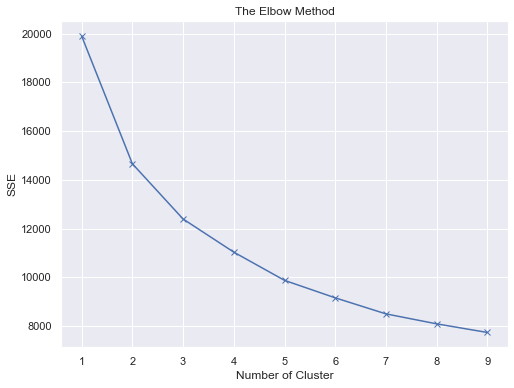

In [25]:
sse= []
for x in range(1,10):
    km = KMeans(n_clusters=x)
    km.fit(scaled_features_df)
    sse.append(km.inertia_)
    
plt.figure(figsize=(8,6))   
plt.plot(range(1,10), sse, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('SSE')
plt.show()

In [26]:
# as seen above our k=3
km =KMeans(n_clusters=3)
y_predicted= km.fit_predict(df1)
df1['Cluster'] = y_predicted
df1.head()

,Education,Marital_Status,Income,Customers_engagement,Age,Kids,Total_expense,TotalAcceptedCmp,TotalNumOfPurchase,Cluster
0,0,1,58138.0,9,64,0,1441,0,22,0
1,0,1,46344.0,7,67,2,20,0,4,0
2,0,0,71613.0,8,56,0,713,0,20,1
3,0,0,26646.0,7,37,1,45,0,6,2
4,0,0,58293.0,7,40,1,380,0,14,0


In [27]:
# plotting the cluster
PLOT = go.Figure()
for C in list(df1.Cluster.unique()):
    

    PLOT.add_trace(go.Scatter3d(x = df1[df1.Cluster == C]['Income'],
                                y = df1[df1.Cluster == C]['Age'],
                                z = df1[df1.Cluster == C]['Total_expense'],                        
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(C)))
PLOT.update_traces(hovertemplate='Income: %{x} <br>Age: %{y} <br>Total_expense: %{z}')

    
PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'Income', titlefont_color = 'black'),
                                yaxis=dict(title = 'Age', titlefont_color = 'black'),
                                zaxis=dict(title = 'Expense', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))